In [1]:
#Adding the libraries
import tensorflow as tf
import numpy as np
import os
import pandas as pd

In [2]:
#diresctory of the train and test dataset
train_dir = r"train"
test_dir = r"test"
os.path.exists(test_dir)

True

In [3]:
#reading the dataset which have all labels of all images
df = pd.read_csv('Training_set.csv')
df.shape

(6499, 2)

In [4]:
all_images_label = df['label'].unique()
all_images_label

<StringArray>
[         'SOUTHERN DOGFACE',                    'ADONIS',
            'BROWN SIPROETA',                   'MONARCH',
  'GREEN CELLED CATTLEHEART',           'CAIRNS BIRDWING',
      'EASTERN DAPPLE WHITE',               'RED POSTMAN',
          'MANGROVE SKIPPER',          'BLACK HAIRSTREAK',
             'CABBAGE WHITE',               'RED ADMIRAL',
              'PAINTED LADY',                'PAPER KITE',
                 'SOOTYWING',                'PINE WHITE',
                   'PEACOCK',        'CHECQUERED SKIPPER',
                     'JULIA',         'COMMON WOOD-NYMPH',
               'BLUE MORPHO',           'CLOUDED SULPHUR',
            'STRAITED QUEEN',            'ORANGE OAKLEAF',
           'PURPLISH COPPER',                     'ATALA',
           'IPHICLUS SISTER',             'DANAID EGGFLY',
              'LARGE MARBLE',          'PIPEVINE SWALLOW',
         'BLUE SPOTTED CROW',               'RED CRACKER',
             'QUESTION MARK',             

In [5]:
import shutil
def move_images(species):
    for images in df.loc[df['label'] == species, 'filename']:
        shutil.move(os.path.join(train_dir, images), os.path.join(os.path.join(train_v2_dir, species), images))

In [6]:
#for labels in uniq:
#    move_images(labels)

In [7]:
# from tensorflow.keras import mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

In [46]:
#prepare the dataset

train_v2_dir = r"train_v2"
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_v2_dir,
    labels='inferred',
    validation_split=0.2,
    subset='training',
    batch_size=32,
    shuffle=True,
    color_mode='rgb',
    seed=123,
    image_size = (128,128)
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_v2_dir,
    labels='inferred',
    validation_split=0.2,
    subset='validation',
    batch_size=32,
    shuffle=True,
    color_mode='rgb',
    seed=123,
    image_size = (128,128)
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels=None,
    batch_size=32,
    shuffle=True,
    color_mode='rgb',
    image_size = (128,128)
)

Found 6499 files belonging to 75 classes.
Using 5200 files for training.
Found 6499 files belonging to 75 classes.
Using 1299 files for validation.
Found 2786 files.


In [47]:
#preprocessing the dataset
train_ds_final = (train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE))
val_ds_final = (val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE))
test_ds_final = (test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE))

In [48]:
#data augmentation and rescaling
aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(0.2,0.2)
])
rescale_input = tf.keras.Sequential([
    tf.keras.layers.Resizing(100,100),
    tf.keras.layers.Rescaling(1./255)
])

In [49]:
#model deployment
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(128,128,3)),
    rescale_input,
    aug,
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu'),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(75,activation='softmax')
])

In [50]:
#custom optimizer
adam = tf.keras.optimizers.Adam(learning_rate=0.0001,epsilon=1e-07)

In [51]:
model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=adam, metrics=['accuracy'])

In [52]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_11 (Sequential)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │     7,930,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 75)             │         9,675 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,214,027 (31.33 MB)

 Trainable params: 8,214,027 (31.33 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
history = model.fit(train_ds_final, validation_data=val_ds_final, epochs=30)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.0202 - loss: 4.2978 - val_accuracy: 0.0300 - val_loss: 4.1830
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.0535 - loss: 3.9972 - val_accuracy: 0.0924 - val_loss: 3.6730
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.0894 - loss: 3.6068 - val_accuracy: 0.1239 - val_loss: 3.4611
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.1265 - loss: 3.3915 - val_accuracy: 0.1324 - val_loss: 3.3842
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.1510 - loss: 3.2330 - val_accuracy: 0.1809 - val_loss: 3.1293
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.1787 - loss: 3.1355 - val_accuracy: 0.1917 - val_loss: 3.0533
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.1994 - loss: 3.0168 - val_accuracy: 0.2148 - val_loss: 2.9150
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.2125 - loss: 2.9340 - val_acc

Text(0.5, 1.0, 'Training and Validation Accuracy')

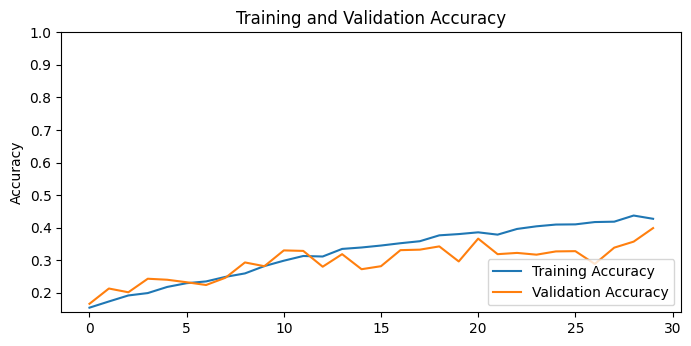

In [45]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

ValueError: Unrecognized data type: x=test\Image_1.jpg (of type <class 'str'>)